# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import matplotlib
import cv2

from pandas.io.parsers import read_csv
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

%matplotlib inline

---
## Step 0: Load The Data

In [2]:
# Load pickled data

training_file = './traffic-signs-data/train.p'
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

sign_desc = read_csv("signnames.csv").values

In [3]:
# Class to encapsulate our data

class TrafficSignImagesData:
    images = None
    labels = None
    signs = None
    indices = None
    label_counts = None
    
    def __init__(self, x, y):
        self.images = x
        self.labels = y
        
        self.signs, self.indices, self.label_counts = np.unique(y, 
                                      return_index = True, return_counts = True)
        
        #print('mean of data: ', self.label_counts.mean())
        
    def get_image_shape(self):
        return self.images[0].shape
    
    def get_data_count(self):
        return len(self.images)
    

training_data = TrafficSignImagesData(X_train, y_train)
validation_data = TrafficSignImagesData(X_validation, y_validation)
test_data = TrafficSignImagesData(X_test, y_test)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = training_data.get_data_count()

# Number of testing examples.
n_test = test_data.get_data_count()

image_shape = training_data.get_image_shape()

# Number of unique classes/labels there are in the dataset.
classes_list, indices, data_counts = np.unique(y_train, return_index = True, return_counts = True)
n_classes = len(classes_list)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Indices = ", indices)
print("Data counts = ", data_counts)
print("Data counts mean= ", data_counts.mean())

sign_names = sign_desc[:, 1]

print(sign_names)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Indices =  [ 9960  2220 31439  5370  6810 12360 21450 23730 15870 11040 17130  8580
 27329 21810 29219 29909  5010 30449 20370  6630 25950 25680  4500  1770
 10800 33449  1230 10350 26849 10560 25020   210 10140 26250 20010 18930
   900  4830 14010 25410  4200     0  9750]
Data counts =  [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920  690
  540  360  990 1080  180  300  270  330  450  240 1350  540  210  480  240
  390  690  210  599  360 1080  330  180 1860  270  300  210  210]
Data counts mean=  809.279069767
['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vehicles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority ro

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

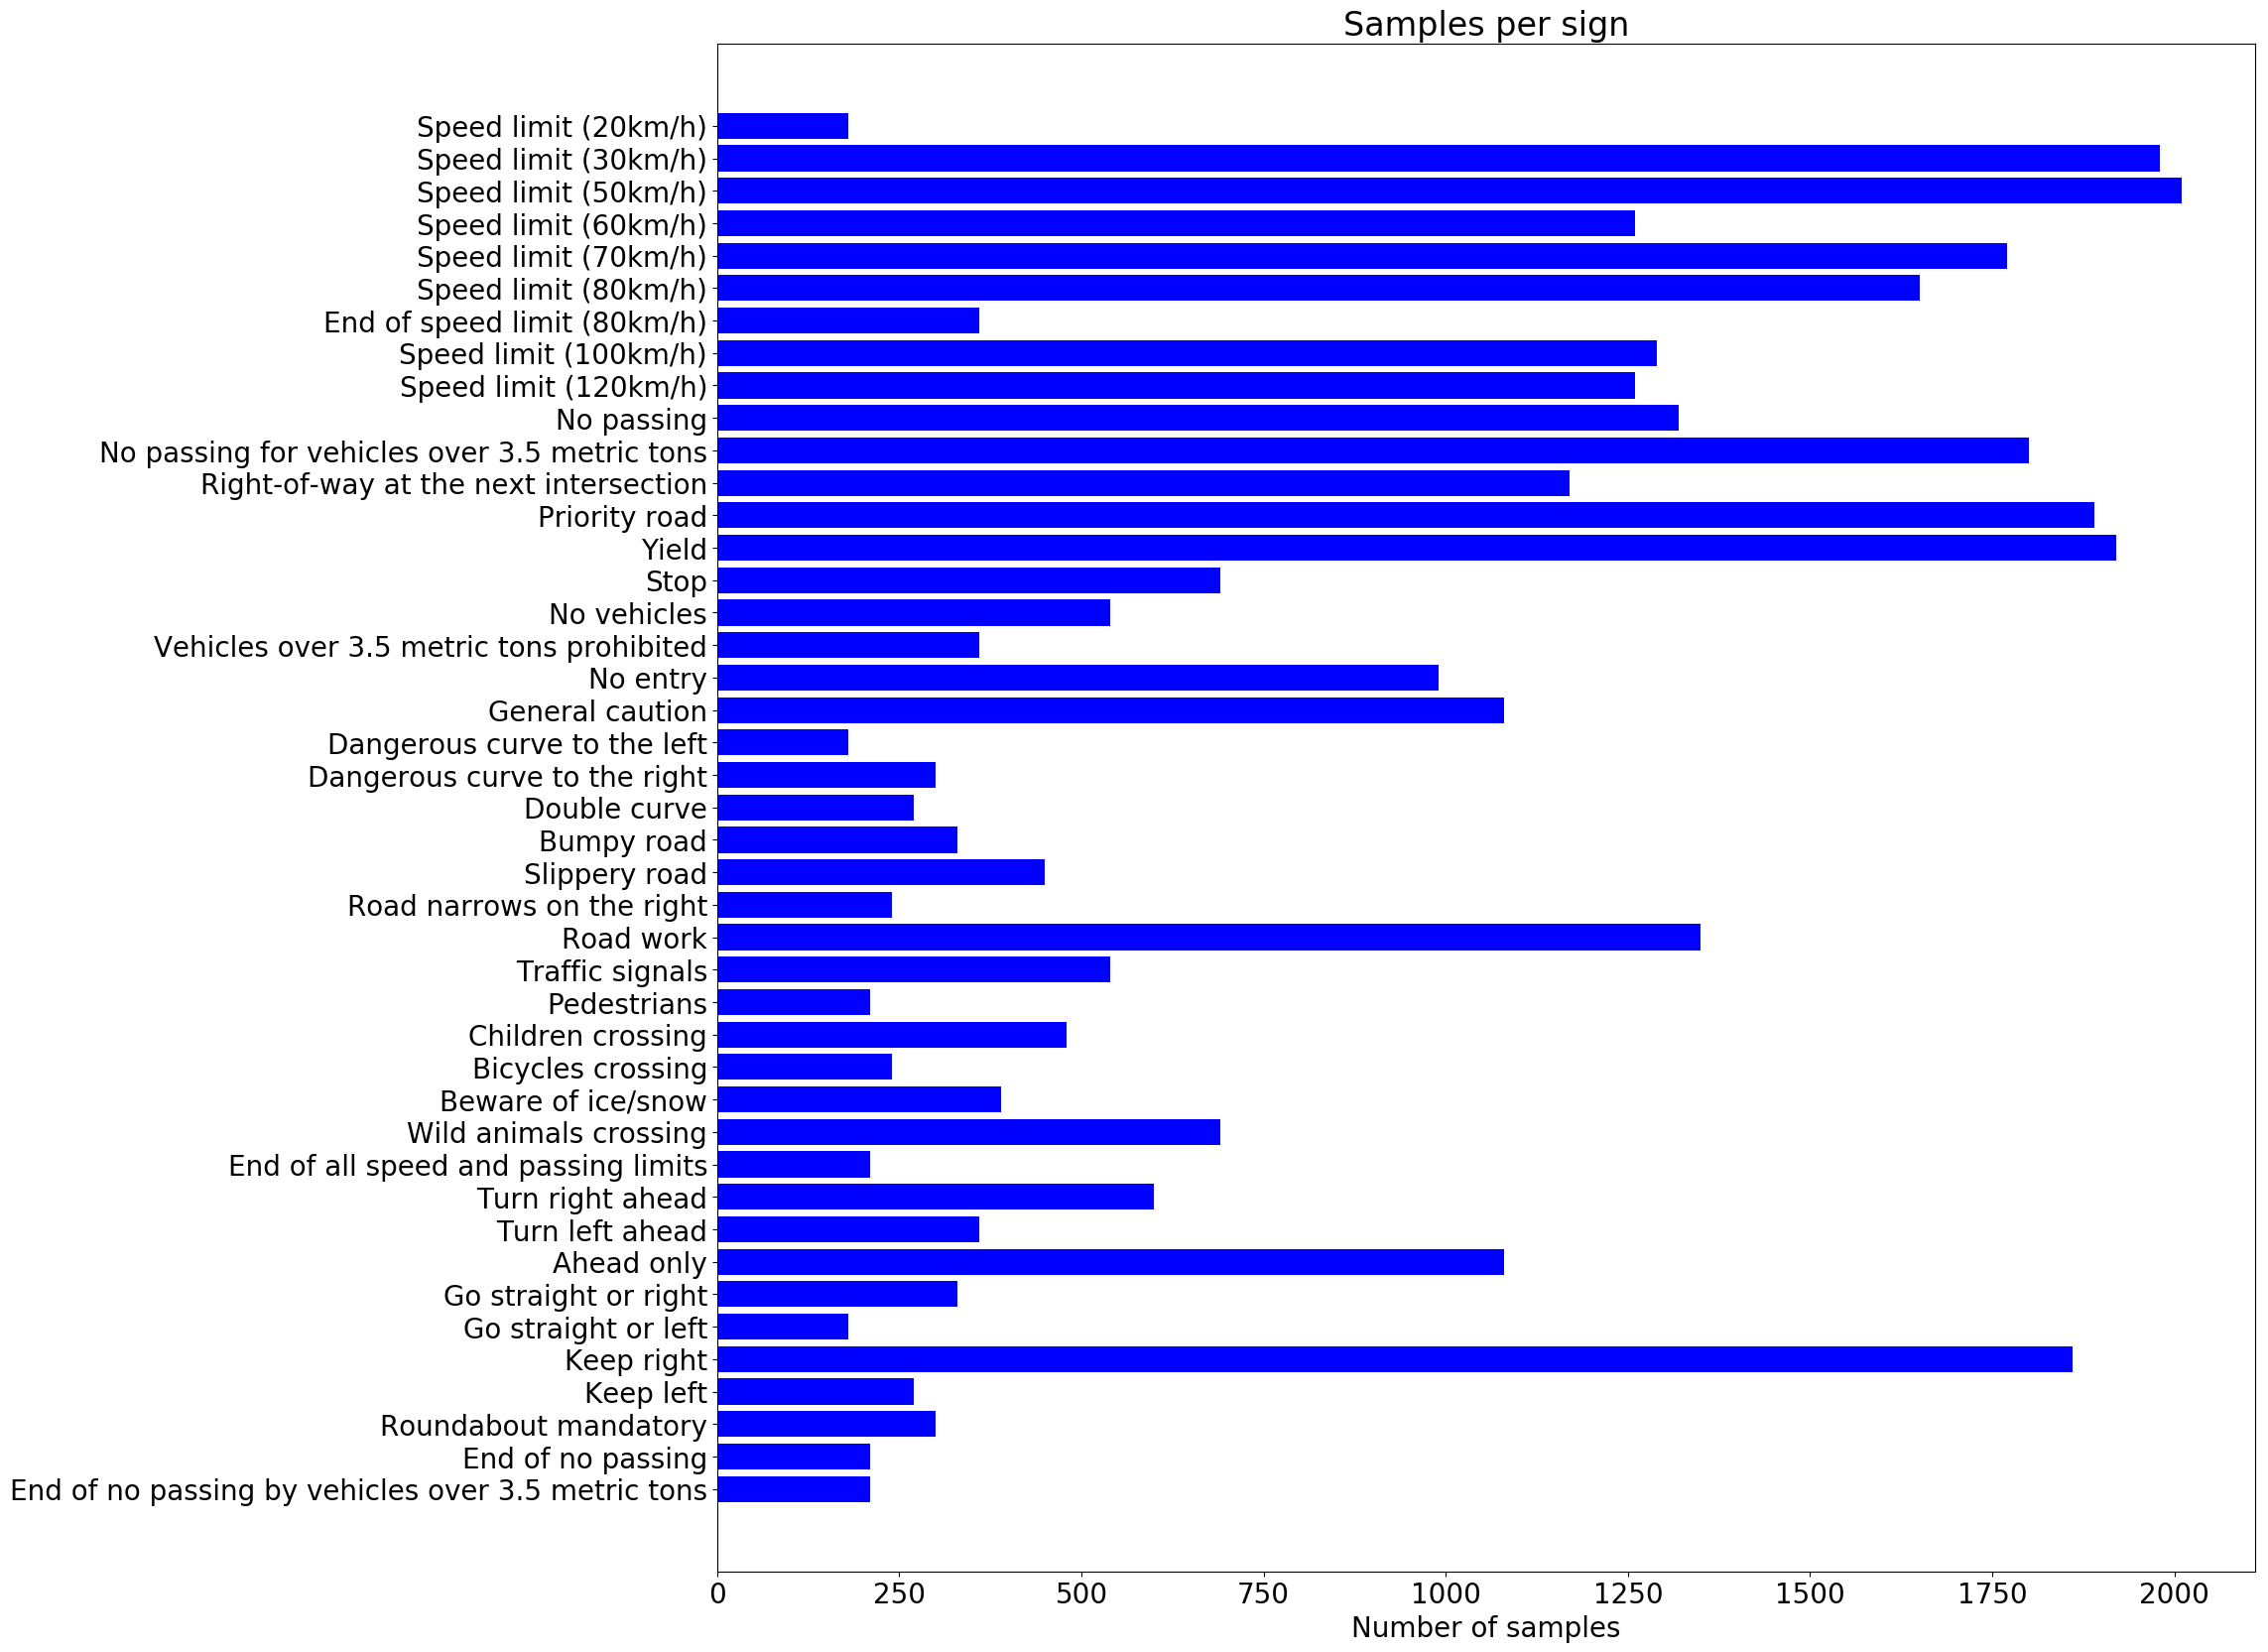

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

plt.rcdefaults()
matplotlib.rcParams.update({'font.size': 20})

def plot_data_counts(signs, d_counts):
    fig, ax = plt.subplots(figsize=(20,20))

    y_pos = np.arange(len(signs))

    ax.barh(y_pos, d_counts, align='center', color='blue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(signs)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Number of samples')
    ax.set_title('Samples per sign')

    plt.show()
    
plot_data_counts(sign_names, data_counts)

In [6]:

def display_sample_images(images, labels, idxs, d_counts):
    matplotlib.rcParams.update({'font.size': 10})
    all_labels_size = len(labels)
    
    show_n_images = 6

    for x in range(all_labels_size):
        
        label = labels[x]
        start_idx = idxs[x]
        fig = plt.figure(figsize = (10, 1))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
        indexes = []
        z = range(0, show_n_images)
        
        for y in z:
            
            axis = fig.add_subplot(1, show_n_images, y+1, xticks=[], yticks=[])
            if (y == 0):
                axis.set_title(str(x) + ' - ' + label)
                
            randx = np.random.randint(0, d_counts[x])
                                      
            idx = start_idx + randx
            indexes.append(idx)
            
            image = images[idx]
            
            axis.imshow(image)
        
    plt.show()



/Users/renelbabia/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


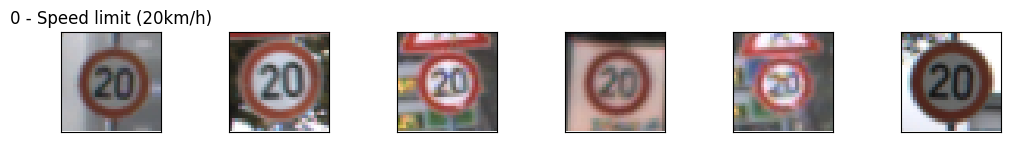

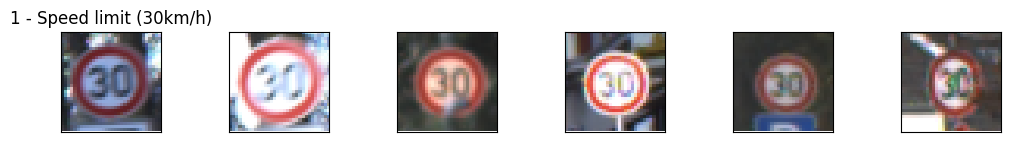

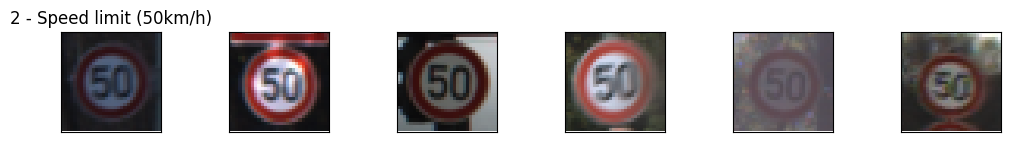

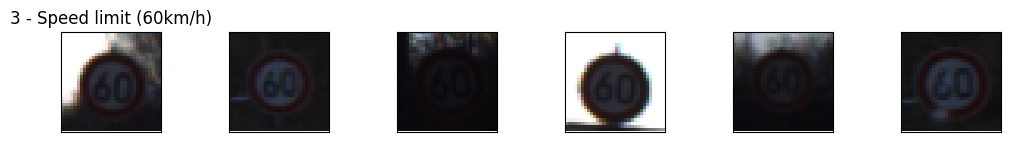

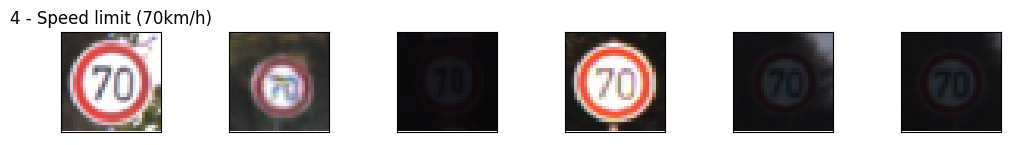

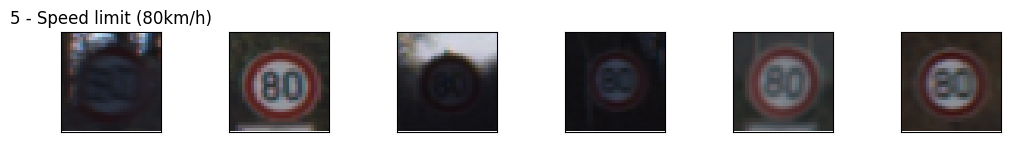

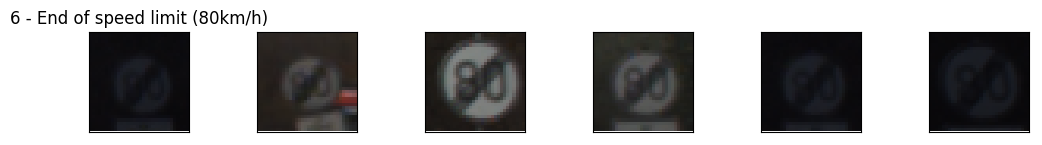

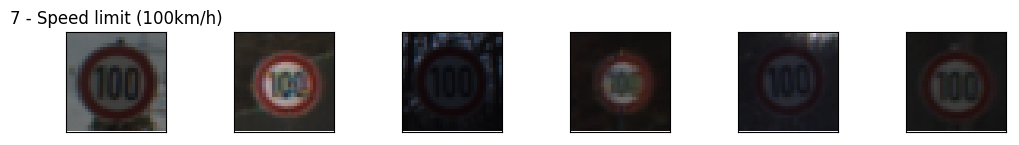

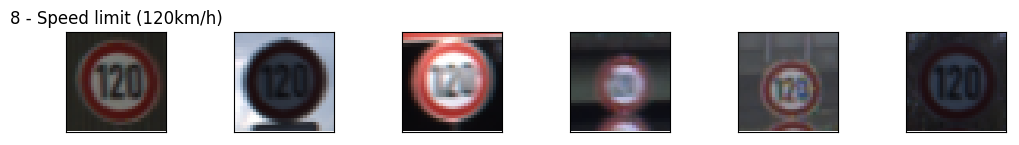

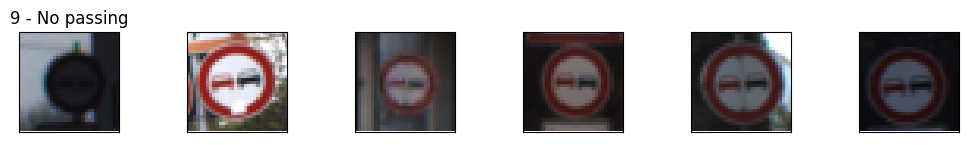

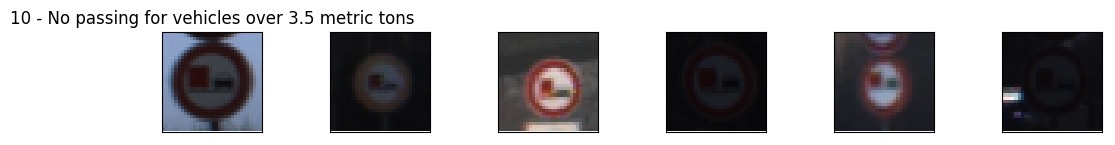

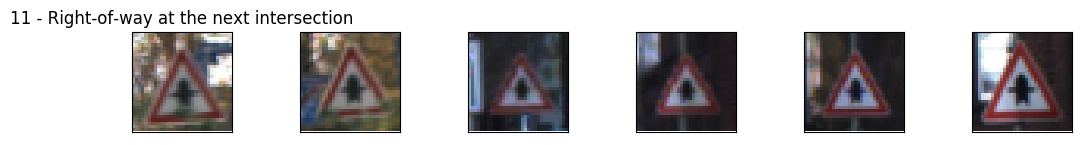

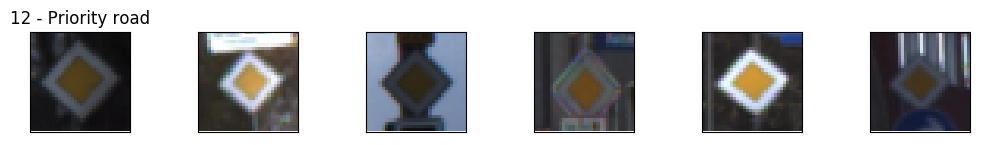

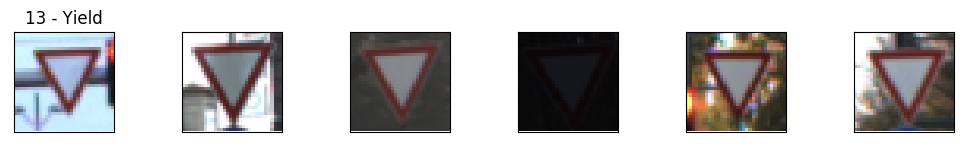

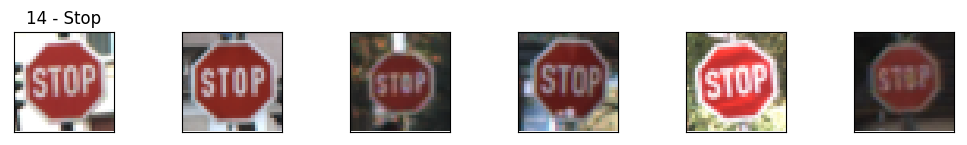

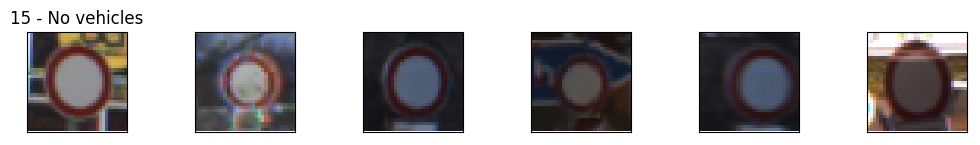

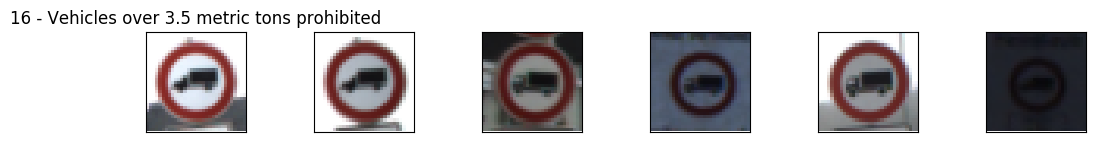

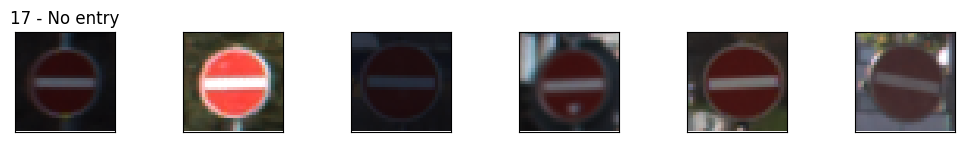

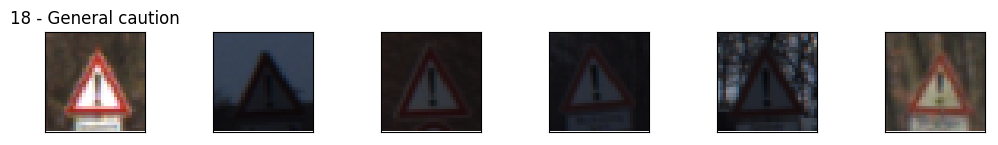

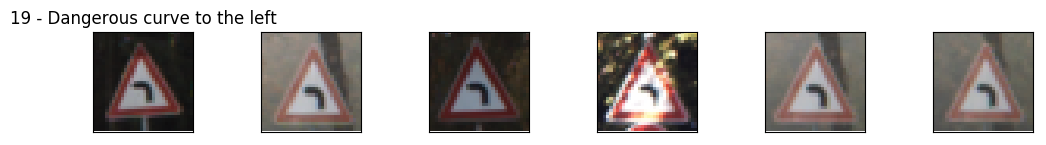

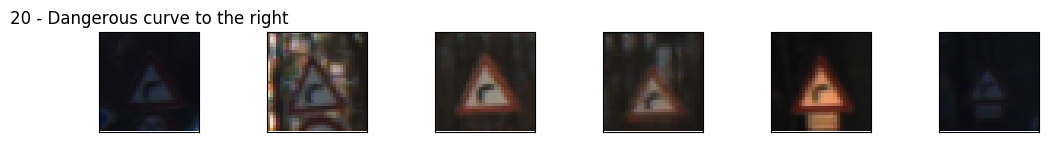

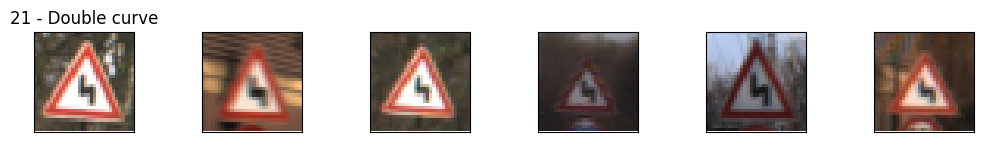

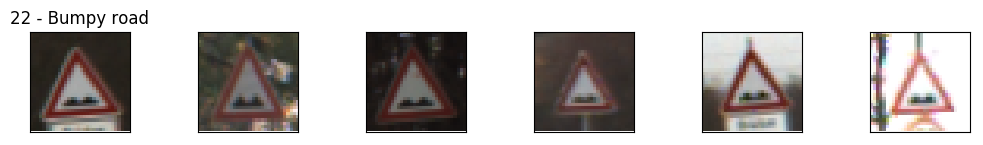

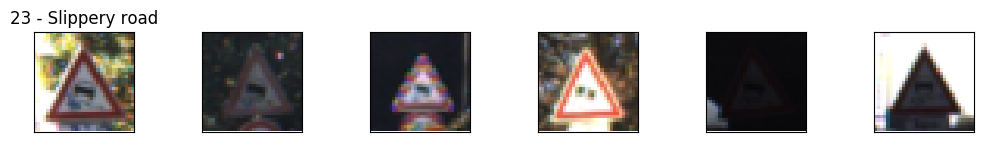

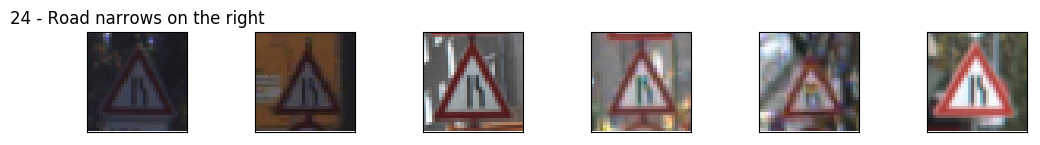

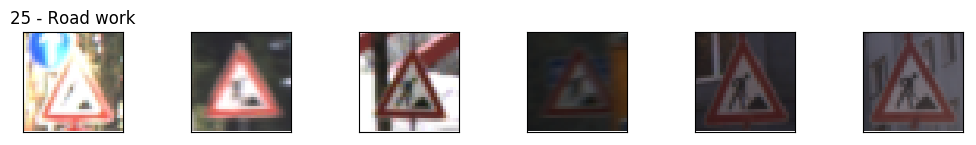

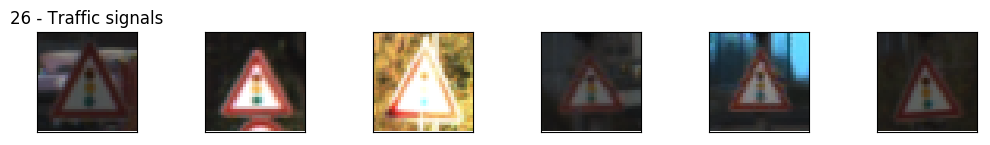

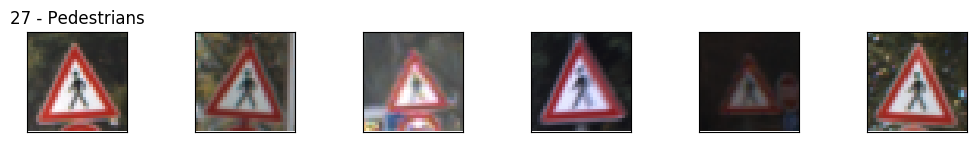

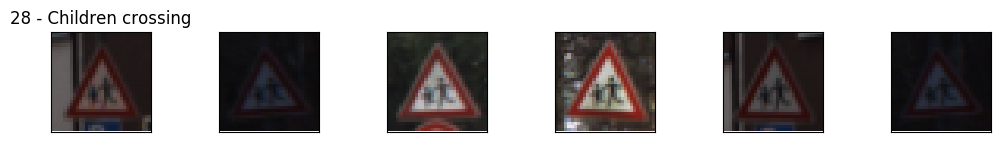

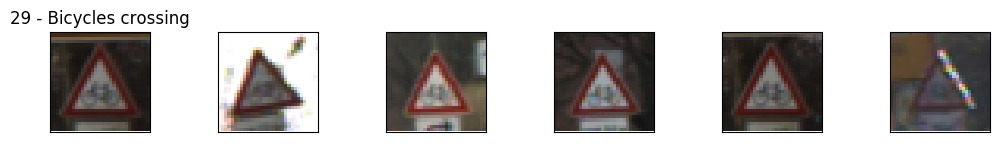

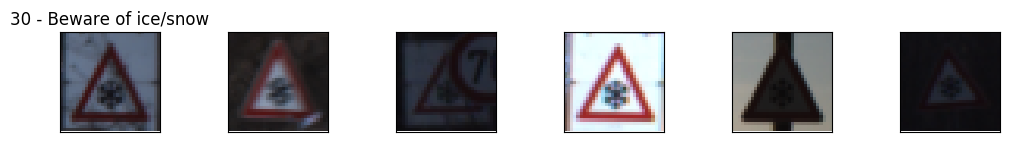

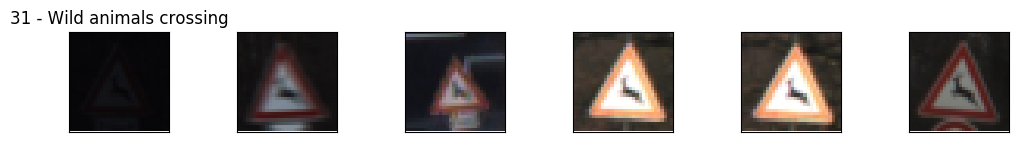

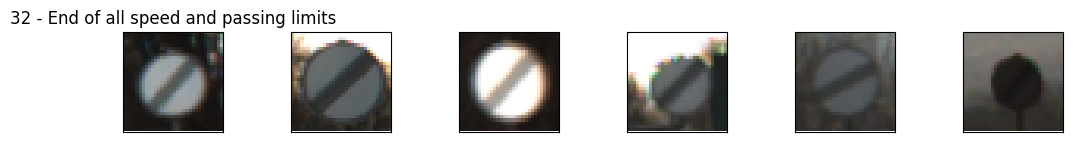

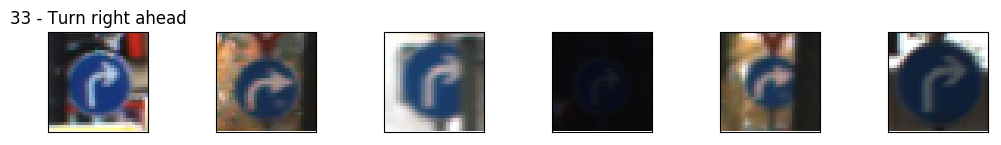

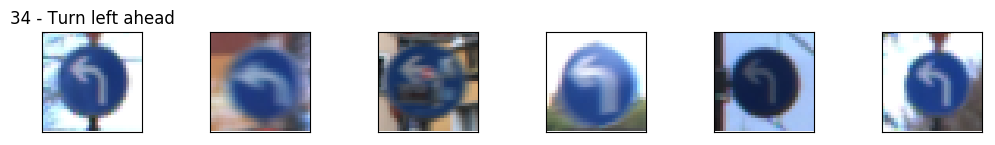

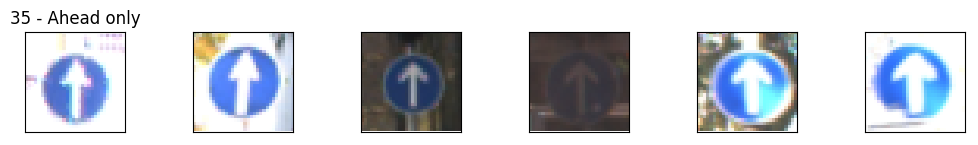

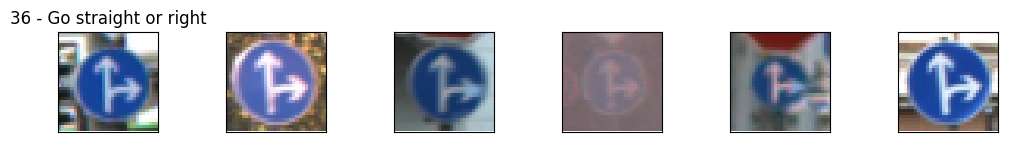

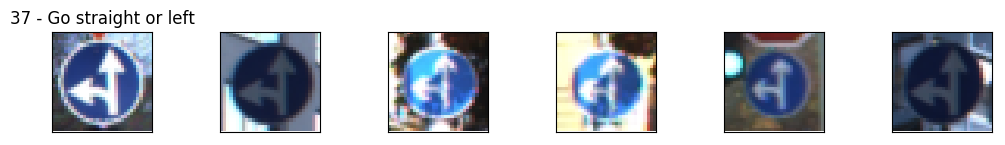

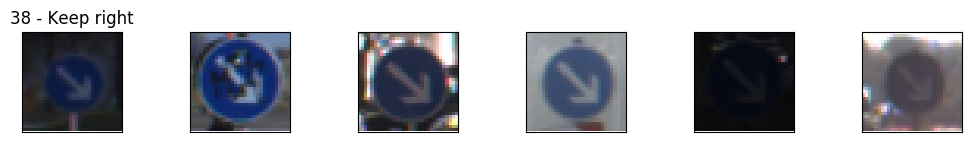

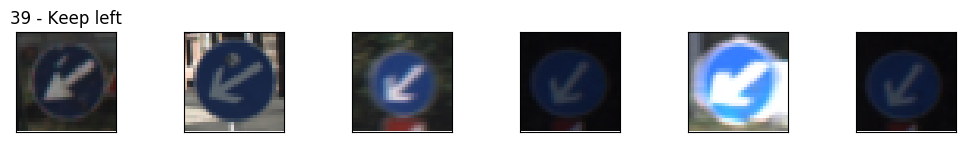

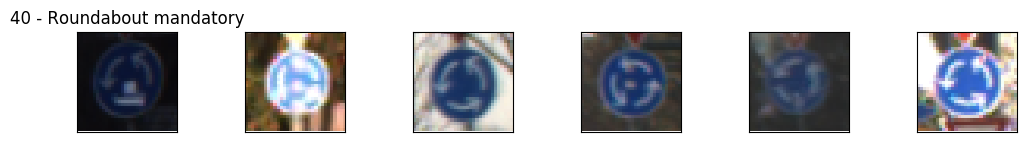

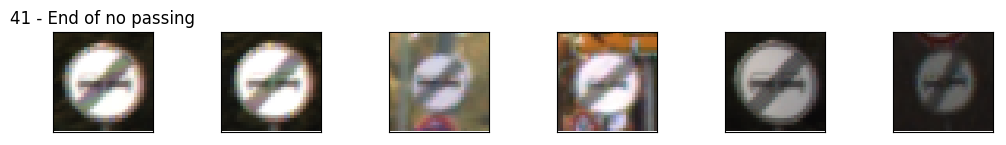

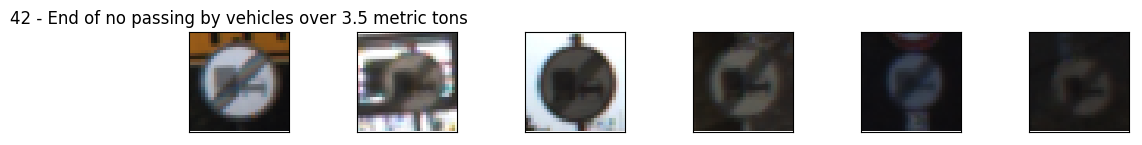

In [7]:
display_sample_images(X_train, sign_names, indices, data_counts)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
# taken from Vivek Yadav
def change_brightness(image):
    # Randomly select a percent change
    change_pct = np.random.uniform(0.4, 1.2)
    
    # Change to HSV to change the brightness V
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * change_pct
    
    #Convert back to RGB 
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return image

def equalize_Hist(img):
    #Histogram Equalization
    img2 = img.copy() 
    img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img2

def change_contrast(img, s=1.0):
    m = 127.0*(1.0-s)
    img2 = cv2.multiply(img, np.array([s]))
    img2 = cv2.add(img2, np.array([m]))
    return img2

# taken from 
# http://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
def adjust_gamma(image):
    g = [1.5,  2. ,  2.5]
    r = np.random.randint(3)
    gamma = g[r]
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [9]:
### Methods to help visualize data

def show_sample_images(image_array, label_array, n_cols):
    plt.figure(figsize=(6, 2))
    
    for i in range(n_cols):
        plt.subplot(1, n_cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image_array[i])
        plt.title(label_array[i])
    
    plt.show()
    
def get_indexes_to_view(data):
    rand_idx = []
    for i in range(5):
        rand_idx.append(np.random.randint(len(data)))

    print(rand_idx)
    return rand_idx

def visualize(index_array, the_images, the_labels):
    sample = []
    sample_l = []
    
    for i in rand_idx:
        sample.append(the_images[i])
        sample_l.append(the_labels[i])
    
    show_sample_images(sample, sample_l, len(index_array))
    

[[[28 25 24]
  [27 24 23]
  [27 24 22]
  ..., 
  [32 28 24]
  [31 27 25]
  [31 27 26]]

 [[29 26 25]
  [27 25 23]
  [27 25 23]
  ..., 
  [32 28 24]
  [31 27 24]
  [30 27 25]]

 [[28 26 26]
  [27 25 23]
  [26 25 23]
  ..., 
  [32 28 24]
  [31 27 24]
  [30 27 25]]

 ..., 
 [[27 24 23]
  [28 25 24]
  [30 25 24]
  ..., 
  [27 24 23]
  [28 24 22]
  [29 25 22]]

 [[28 23 23]
  [29 24 24]
  [31 25 24]
  ..., 
  [27 24 23]
  [28 24 22]
  [28 24 21]]

 [[29 23 23]
  [30 24 24]
  [32 24 23]
  ..., 
  [27 24 22]
  [27 23 21]
  [26 22 20]]]
data counts:
[ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920  690
  540  360  990 1080  180  300  270  330  450  240 1350  540  210  480  240
  390  690  210  599  360 1080  330  180 1860  270  300  210  210]

indices:
[ 9960  2220 31439  5370  6810 12360 21450 23730 15870 11040 17130  8580
 27329 21810 29219 29909  5010 30449 20370  6630 25950 25680  4500  1770
 10800 33449  1230 10350 26849 10560 25020   210 10140 26250 20010 18930
   9

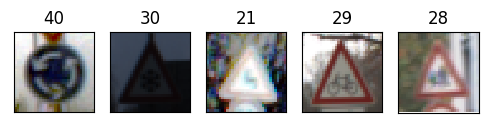

In [10]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import copy
import math

updated_data_counts = copy.copy(training_data.label_counts)

def augment_data(data):
    print(data.images[0])
    new_x = []
    new_y = []
    
    #updated_data_counts = copy.copy(data.label_counts)

    print('data counts:')
    print(updated_data_counts)
    print()
    print('indices:')
    print(indices)

    target_numdata = math.ceil(data.label_counts.mean())
    target_numdata = data.label_counts.max()
    
    print('target_numdata:', target_numdata)
    
    i = 0
    
    for sign_code, dc, idx in zip(sign_desc[:, 0], updated_data_counts, data.indices):
        

        if (dc < target_numdata):

            numloops = target_numdata - dc

            x = 0
            for n in range(numloops):

                if (x >= dc):
                    x = 0
                else:
                    x += 1

                imgidx = idx + x

                image = data.images[imgidx]

                # modify image and add to our data
                r = np.random.randint(3)

                if (r == 0):
                    image = change_brightness(image)
                    
                if (r == 1):    
                    image = equalize_Hist(image)
                    
                if (r == 2):
                    image = adjust_gamma(image)
                
                new_x.append(image)
                new_y.append(sign_code)
                
            dc = dc + numloops
            updated_data_counts[i] = dc
            
        i += 1

    print('updated data counts:')
    print(updated_data_counts)
    print('updated data counts length: ', len(updated_data_counts))
    
    print('new data created = ', len(new_x), ' labels: ', np.unique(new_y))
    
    aug_x = np.array(new_x)
    aug_y = np.array(new_y)

    print('xxx - ', len(aug_x), ' orig - ', len(data.images))
    retval = TrafficSignImagesData(aug_x, aug_y)
    
    return retval
        
augmented_data = augment_data(training_data)

rand_idx = get_indexes_to_view(augmented_data.images)

print('sample augmented')
visualize(rand_idx, augmented_data.images, augmented_data.labels)

In [11]:
print('new data count = ', augmented_data.get_data_count())
print('new indices = ',augmented_data.indices)
print('new label counts = ',augmented_data.label_counts)
print('new label counts = ',augmented_data.label_counts)


new data count =  51631
new indices =  [    0  1830  1860  2610  2850  3210  4860  5580  6330  7020  7230  8070
  8190  8280  9600 11070 12720 13740 14670 16500 18210 19950 21630 23190
 24960 25620 27090 28890 30420 32190 33810 35130 36930 38341 39991 40921
 42601 44431 44581 46321 48031 49831]
new label counts =  [1830   30  750  240  360 1650  720  750  690  210  840  120   90 1320 1470
 1650 1020  930 1830 1710 1740 1680 1560 1770  660 1470 1800 1530 1770 1620
 1320 1800 1411 1650  930 1680 1830  150 1740 1710 1800 1800]
new label counts =  [1830   30  750  240  360 1650  720  750  690  210  840  120   90 1320 1470
 1650 1020  930 1830 1710 1740 1680 1560 1770  660 1470 1800 1530 1770 1620
 1320 1800 1411 1650  930 1680 1830  150 1740 1710 1800 1800]


43


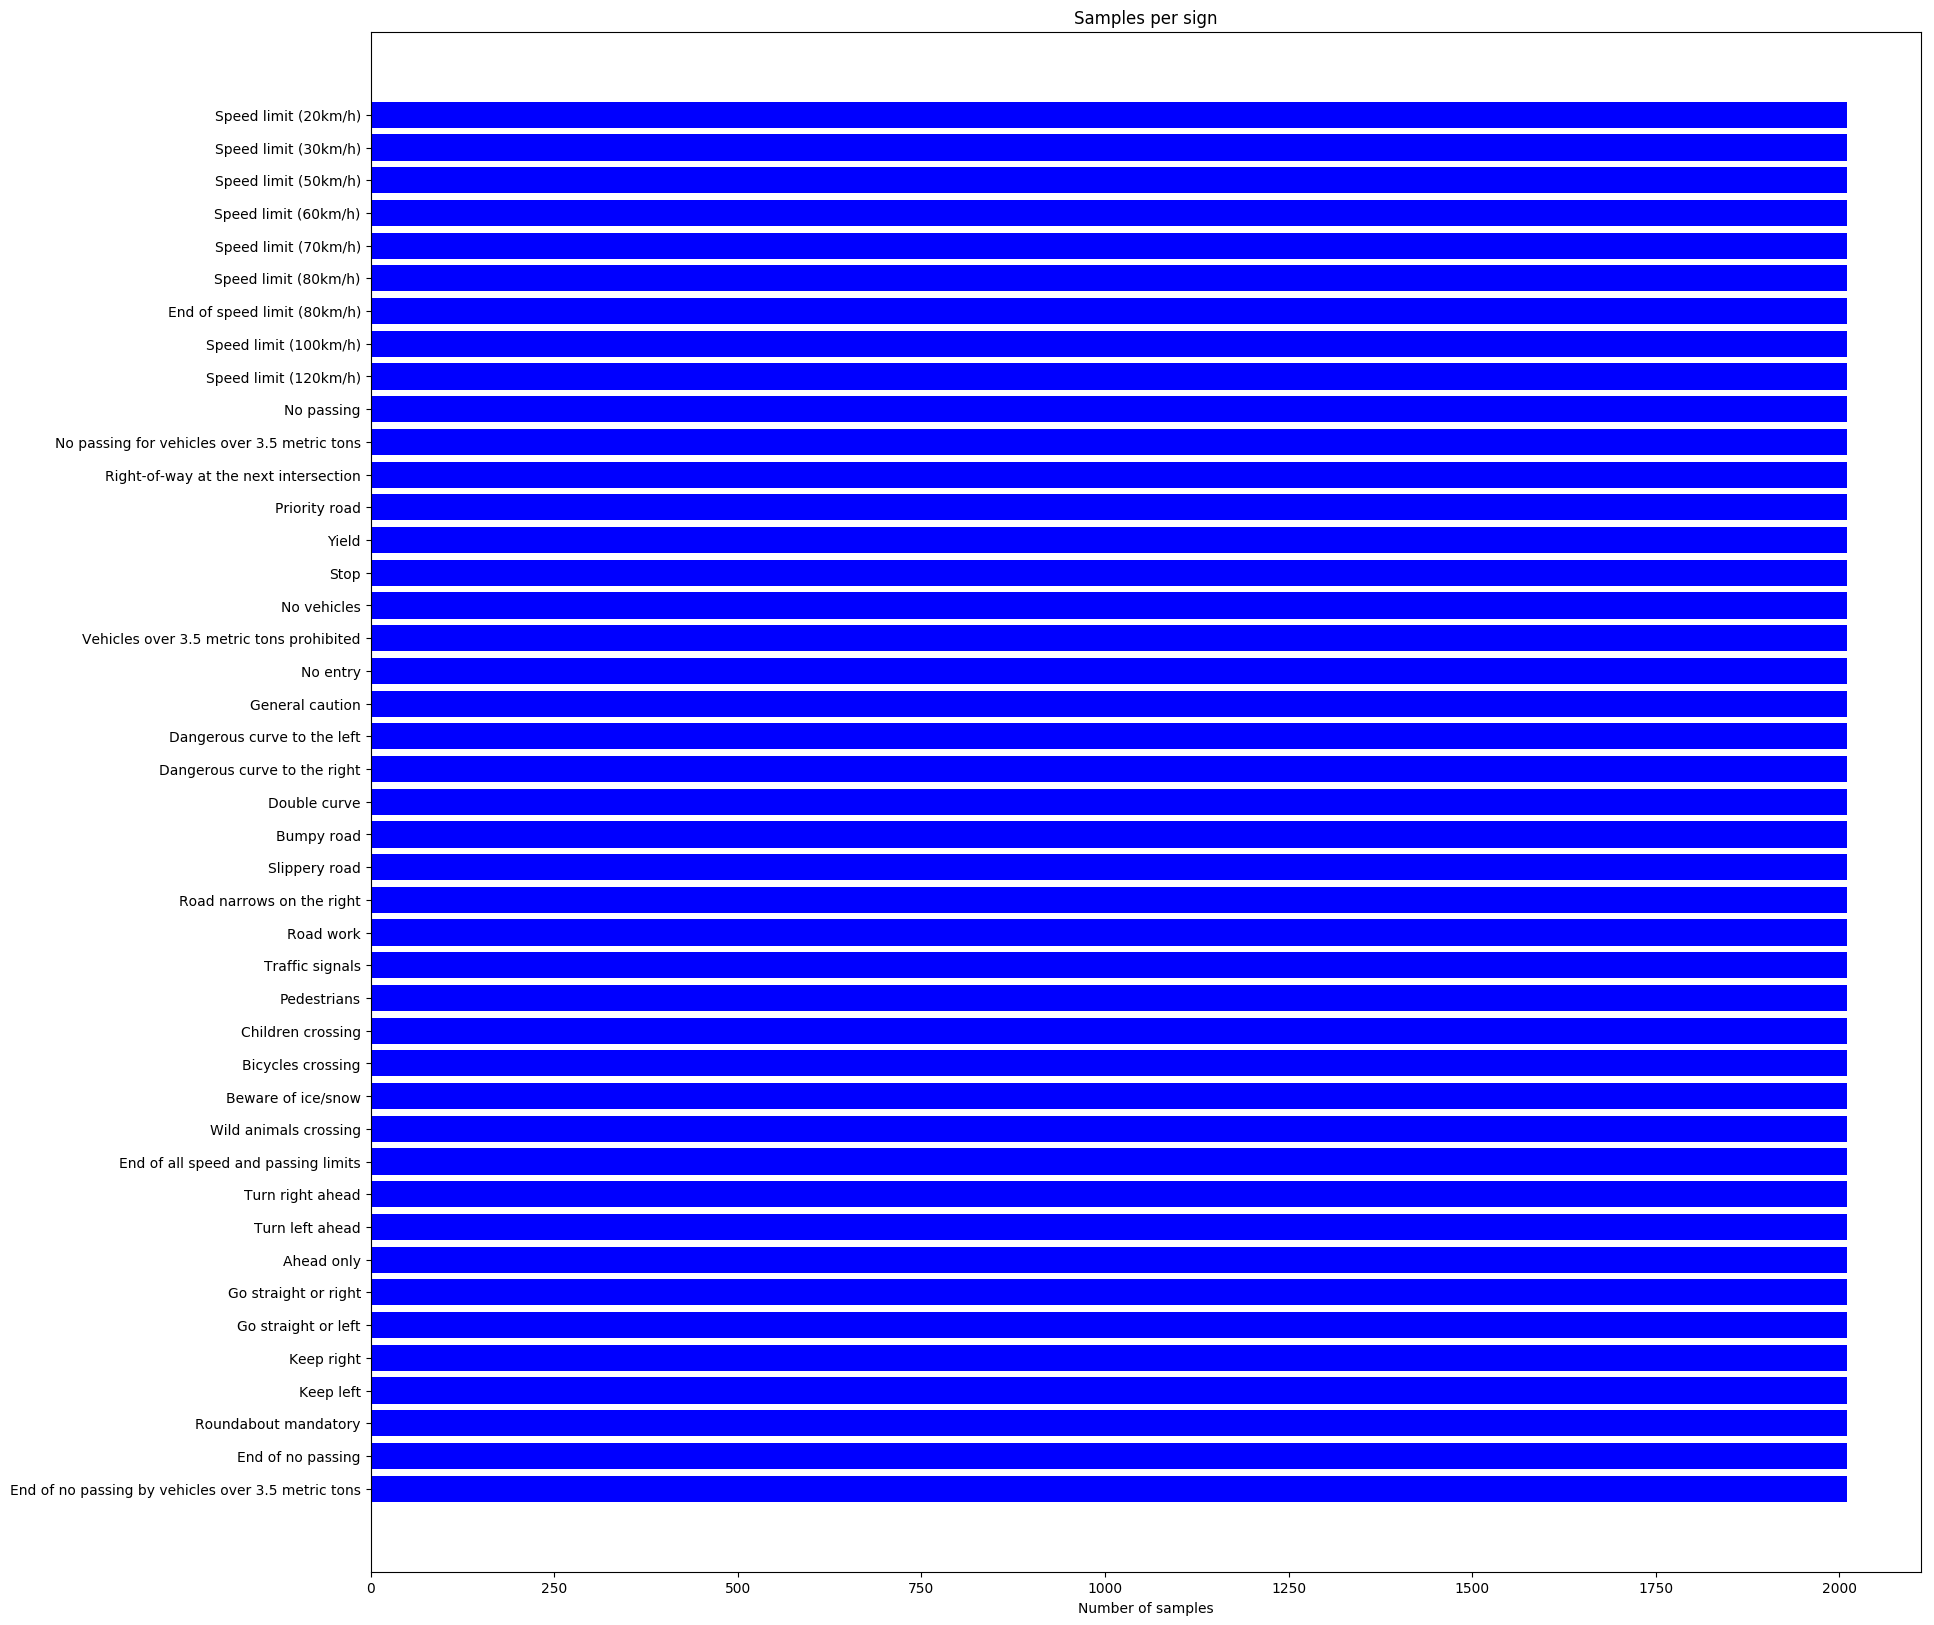

In [12]:
print(len(updated_data_counts))
plot_data_counts(sign_names, updated_data_counts)

In [13]:
# Normalise input 
def normalize_input(data):
    norm = (data - data.mean()) / (np.max(data) - np.min(data))
    
    return norm


shape:  (32, 32, 3)
[59910, 6011, 37856, 27672, 15365]
sample augmented


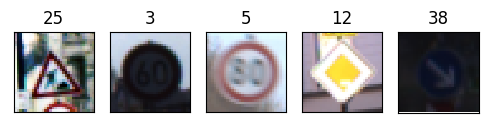

(32, 32, 3)
sample after normalized


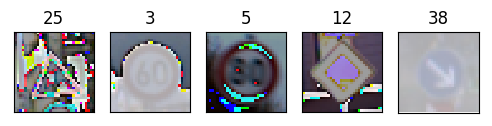

[1670, 2042, 4235, 595, 2035]
sample validation data


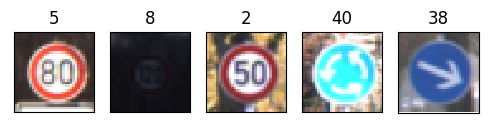

sample validation data after normalized


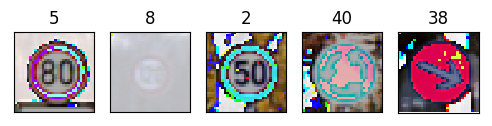

[12601, 2312, 4106, 6064, 10166]
sample test data


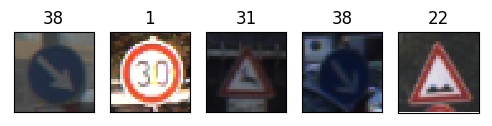

sample test data after normalized


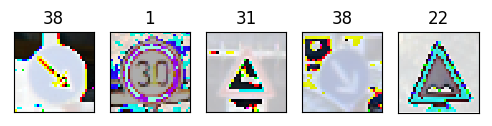

In [14]:
X_train_aug = augmented_data.images
Y_train_aug = augmented_data.labels

X_train_aug = np.concatenate((training_data.images, augmented_data.images))
Y_train_aug = np.concatenate((training_data.labels, augmented_data.labels))


print('shape: ', X_train_aug[0].shape)

    
rand_idx = get_indexes_to_view(X_train_aug)

print('sample augmented')
visualize(rand_idx, X_train_aug, Y_train_aug)

# normalize training data
X_train_normalized = normalize_input(X_train_aug)


print(X_train_normalized[0].shape)

print('sample after normalized')    
visualize(rand_idx, X_train_normalized, Y_train_aug)

rand_idx = get_indexes_to_view(validation_data.images)

print('sample validation data')
visualize(rand_idx, validation_data.images, validation_data.labels)

# normalize validation data
X_valid_normalized = normalize_input(validation_data.images)

print('sample validation data after normalized')
visualize(rand_idx, X_valid_normalized, validation_data.labels)

rand_idx = get_indexes_to_view(test_data.images)

print('sample test data')
visualize(rand_idx, test_data.images, test_data.labels)

# normalize validation data
X_test_normalized = normalize_input(test_data.images)

print('sample test data after normalized')
visualize(rand_idx, X_test_normalized, test_data.labels)


### Model Architecture

In [15]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    fc1 = tf.nn.dropout(fc1, 0.7)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    fc2    = tf.nn.dropout(fc2, 0.7)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits



### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
EPOCHS = 23
BATCH_SIZE = 128

In [17]:
### Train your model here.
# tf Graph input
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# Model
logits = LeNet(x)

# Define loss and optimizer
rate = 0.0005

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss/num_examples, total_accuracy / num_examples



### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [18]:
# Initializing the variables
init = tf. global_variables_initializer()

acc = np.zeros(6)

train_loss_history = []
valid_loss_history = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    num_examples = len(X_train_normalized)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        print("EPOCH {} ...".format(i+1))
        
        X_train_normalized, Y_train_aug = shuffle(X_train_normalized, Y_train_aug)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], Y_train_aug[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        training_loss, training_accuracy = evaluate(X_train_normalized, Y_train_aug)
        validation_loss, validation_accuracy = evaluate(X_valid_normalized, y_validation)
        
        train_loss_history.append(training_loss)
        valid_loss_history.append(validation_loss)
        
        acc = np.append(acc, validation_accuracy)
        
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, './lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Training Accuracy = 0.725
Validation Accuracy = 0.651
EPOCH 2 ...
Training Accuracy = 0.858
Validation Accuracy = 0.783
EPOCH 3 ...
Training Accuracy = 0.894
Validation Accuracy = 0.830
EPOCH 4 ...
Training Accuracy = 0.914
Validation Accuracy = 0.843
EPOCH 5 ...
Training Accuracy = 0.929
Validation Accuracy = 0.867
EPOCH 6 ...
Training Accuracy = 0.942
Validation Accuracy = 0.893
EPOCH 7 ...
Training Accuracy = 0.947
Validation Accuracy = 0.891
EPOCH 8 ...
Training Accuracy = 0.952
Validation Accuracy = 0.901
EPOCH 9 ...
Training Accuracy = 0.958
Validation Accuracy = 0.905
EPOCH 10 ...
Training Accuracy = 0.963
Validation Accuracy = 0.908
EPOCH 11 ...
Training Accuracy = 0.964
Validation Accuracy = 0.912
EPOCH 12 ...
Training Accuracy = 0.966
Validation Accuracy = 0.920
EPOCH 13 ...
Training Accuracy = 0.970
Validation Accuracy = 0.919
EPOCH 14 ...
Training Accuracy = 0.972
Validation Accuracy = 0.925
EPOCH 15 ...
Training Accuracy = 0.972
Validation Accuracy

train_loss_history
[0.97395852075383904, 0.54182669873123412, 0.38973400755556425, 0.32002055829326875, 0.26491251688484624, 0.22061977067210808, 0.19882972979644209, 0.17705718526392777, 0.1577787197772019, 0.13937555367208307, 0.13242924878142931, 0.12613209792823685, 0.11521002651260888, 0.10339152573932311, 0.099591850751695646, 0.091682276198340698, 0.091166981110090903, 0.088056023486659418, 0.080711265868708498, 0.078228240559205381, 0.075457343408312283, 0.071579762255837814, 0.063115596297809842]
valid_loss_history
[1.136462215825814, 0.73809371278399516, 0.56697789827982581, 0.53435293265751427, 0.45794936350954363, 0.39436196372622534, 0.38179587838060464, 0.351279640190996, 0.36121928460743963, 0.34862137312521468, 0.36790601698990039, 0.32068588523502523, 0.33586305594092863, 0.32453917367658375, 0.31596552302507586, 0.29751312507658589, 0.30750273277733869, 0.37003675182761792, 0.32695136511542089, 0.31159252741980176, 0.32913911218782399, 0.31339407525027418, 0.323487444

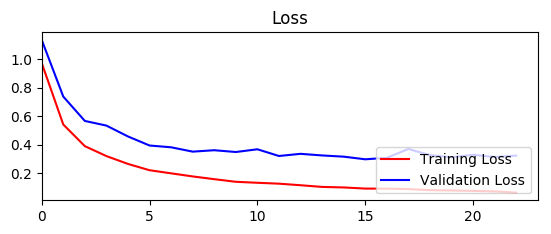

In [19]:
print('train_loss_history')
print(train_loss_history)

print('valid_loss_history')
print(valid_loss_history)

loss_plot = plt.subplot(2,1,1)
loss_plot.set_title('Loss')
loss_plot.plot(train_loss_history, 'r', label='Training Loss')
loss_plot.plot(valid_loss_history, 'b', label='Validation Loss')
loss_plot.set_xlim([0, EPOCHS])
loss_plot.legend(loc=4)
plt.show()

In [21]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy[1]))

Test Accuracy = 0.914


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

(474, 720, 3)
(32, 32, 3)
(526, 720, 3)
(32, 32, 3)
(482, 720, 3)
(32, 32, 3)
(589, 800, 3)
(32, 32, 3)
(532, 800, 3)
(32, 32, 3)


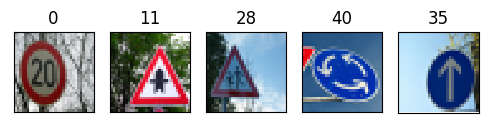

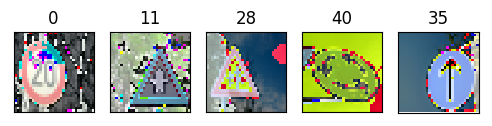

In [22]:
import glob

### Load the images and plot them here.
### Feel free to use as many code cells as needed.

my_images = []
my_labels = [0, 11, 28, 40, 35]

for i, img in enumerate(glob.glob('./fromweb/traffic*.jpg')):
    image = cv2.imread(img)
    print(image.shape)
    
    r = 100.0 / image.shape[1]
    dim = (32, 32)
 
    # perform the actual resizing of the image and show it
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    b,g,r = cv2.split(resized)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb

    #img = cv2.resize(image, (32, 32))
    
    print(rgb_img.shape)
    #axs[i].axis('off')
    #axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    my_images.append(rgb_img)

show_sample_images(my_images, my_labels, 5)
my_images = np.asarray(my_images)

my_images_gry = np.sum(my_images/3, keepdims=True)

my_images_normalized = normalize_input(my_images) 

show_sample_images(my_images_normalized, my_labels, 5)

#print(my_images_normalized.shape)

### Predict the Sign Type for Each Image

In [24]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_accuracy = evaluate(my_images_normalized, my_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy[1]))

Test Set Accuracy = 0.200


### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [25]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)
keep_prob = tf.placeholder(tf.float32)

my_top_k = None
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_images_normalized})
    #my_top_k = sess.run(top_k, feed_dict={x: my_images_normalized, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: my_images_normalized})
    
    print(my_top_k)

TopKV2(values=array([[  4.33288932e-01,   2.04760998e-01,   8.35226551e-02],
       [  4.39004332e-01,   1.10474214e-01,   1.00744687e-01],
       [  2.16776684e-01,   1.57541841e-01,   1.10159293e-01],
       [  9.99896288e-01,   1.03494931e-04,   1.17737414e-07],
       [  9.99782503e-01,   1.02976344e-04,   9.69061148e-05]], dtype=float32), indices=array([[34, 18, 17],
       [18, 22, 28],
       [26, 11, 37],
       [40, 37, 39],
       [33, 34, 35]], dtype=int32))


[[  4.33288932e-01   2.04760998e-01   8.35226551e-02]
 [  4.39004332e-01   1.10474214e-01   1.00744687e-01]
 [  2.16776684e-01   1.57541841e-01   1.10159293e-01]
 [  9.99896288e-01   1.03494931e-04   1.17737414e-07]
 [  9.99782503e-01   1.02976344e-04   9.69061148e-05]]
[[34 18 17]
 [18 22 28]
 [26 11 37]
 [40 37 39]
 [33 34 35]]



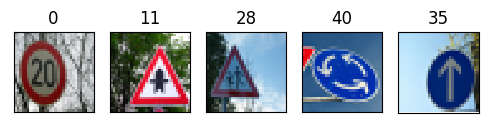

0
[ 0.43328893  0.204761    0.08352266]
[34 18 17]

11
[ 0.43900433  0.11047421  0.10074469]
[18 22 28]

28
[ 0.21677668  0.15754184  0.11015929]
[26 11 37]

40
[  9.99896288e-01   1.03494931e-04   1.17737414e-07]
[40 37 39]

35
[  9.99782503e-01   1.02976344e-04   9.69061148e-05]
[33 34 35]



In [26]:
print(my_top_k[0])
print(my_top_k[1])
print()

show_sample_images(my_images, my_labels, 5)

for i, x, y in zip(range(5), my_top_k[0], my_top_k[1]):
        
    print(my_labels[i])
    print(x)
    print(y)
    print()

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 